In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


We start by implementing the algorithm proposed by Hanie Sedghi, Vineet Gupta, and Philip M. Long in the paper *"The Singular Values of Convolutional Layers"*, published at the ICLR 2019 conference. This algorithm makes it possible to efficiently compute the spectral norm (i.e., the operator norm) of the matrix $\operatorname{op}(K)$ associated with a convolution kernel $K$.

Paper link: https://arxiv.org/abs/1805.10408

As a reminder:
$
K^{(i)}, K_{0}^{(i)} \in \mathbb{R}^{k \times k \times c \times c} \quad \forall i = 1,\dots,L
$

and

$$
\|K - K_0\|_{\sigma} \stackrel{\mathrm{def}}{=}
\sum_{i=1}^{L} \left\| \operatorname{op}\!\bigl(K^{(i)}\bigr) - \operatorname{op}\!\bigl(K_0^{(i)}\bigr) \right\|_{2}
$$

where $\|\cdot\|_{2}$ denotes the operator norm.


In [4]:

# The Sedghi et al. Algorithm

def compute_spectral_norm_sedghi(conv_layer, input_spatial_shape):
    """
    Computes the spectral norm (operator norm) of a convolution layer
    using the FFT method

    Args:
        conv_layer: torch.nn.Conv2d layer
        input_spatial_shape: tuple (H, W) of the input image size
    """
    weights = conv_layer.weight.detach() # Shape : (Out, In, K, K)
    out_c, in_c, k_h, k_w = weights.shape
    H, W = input_spatial_shape

    # We first pad the kernel to the size of the input image (H, W)

    pad_h = H - k_h
    pad_w = W - k_w

    # We place the kernel in the corner
    padded_weight = torch.nn.functional.pad(weights, (0, pad_w, 0, pad_h))

    # We compute 2D FFT over spatial dimensions

    fft_weights = torch.fft.fft2(padded_weight, s=(H, W), dim=(-2, -1))

    # Then we rearrange to (H, W, Out, In) to form matrices for each frequency (u, v)
    fft_weights = fft_weights.permute(2, 3, 0, 1)

    # We compute Singular Values for each frequency matrix M^{(u,v)}


    S = torch.linalg.svdvals(fft_weights) # Shape: (H, W, min(Out, In))

    # The spectral norm of the conv operator is the global maximum singular value
    spectral_norm = S.max().item()

    return spectral_norm

def compute_distance_from_init(model, initial_model, input_shape):
    """
    Computes ||K - K0||_sigma using the Sedghi method.
    """
    distance = 0.0

    # Iterate over layers
    for (name1, layer1), (name2, layer2) in zip(model.named_modules(), initial_model.named_modules()):
        if isinstance(layer1, nn.Conv2d):
            # Calculate op(K) - op(K0)
            diff_layer = nn.Conv2d(layer1.in_channels, layer1.out_channels,
                                   layer1.kernel_size, layer1.stride, layer1.padding)
            diff_layer.weight.data = layer1.weight.data - layer2.weight.data

            # Compute spectral norm of difference
            norm = compute_spectral_norm_sedghi(diff_layer, input_shape)
            distance += norm

    return distance


In [5]:

#  Model and Experiment Setup

# We build sequentialy a small toy cnn with only 3 conv to make computations faster
class SimpleCNN(nn.Module):
    def __init__(self, width_scale):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4 * width_scale, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * width_scale, 8 * width_scale, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8 * width_scale, 8 * width_scale, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(8 * width_scale * 7 * 7, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


@torch.no_grad()
def classification_error(model, loader, device):
    model.eval()
    total = 0
    incorrect = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        total += y.numel()
        incorrect += (pred != y).sum().item()
    return incorrect / total


def run_experiment():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # We use a subset for speed (train)
    subset_indices = range(0, 5000)
    trainset_subset = torch.utils.data.Subset(trainset, subset_indices)

    trainloader = torch.utils.data.DataLoader(trainset_subset, batch_size=64, shuffle=True)
    testloader  = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on {device}")

    widths = [1, 2, 4, 8, 16]
    distances = []
    param_counts = []
    gen_gaps = []
    W_times_dist = []

    for w in widths:
        print(f"\nTraining Network with Width Scale: {w}")

        # Initialize model and copy for K0
        model = SimpleCNN(width_scale=w).to(device)
        initial_model = SimpleCNN(width_scale=w).to(device)
        initial_model.load_state_dict(model.state_dict())

        # Count parameters (W)
        total_params = sum(p.numel() for p in model.parameters())
        param_counts.append(total_params)

        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        # Train
        model.train()
        for epoch in tqdm(range(5)):
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Distance from init: ||K-K0||_sigma
        dist = compute_distance_from_init(model, initial_model, (28, 28))
        distances.append(dist)
        W_times_dist.append(total_params * dist)

        # Generalization gap: |train_err - test_err|
        train_err = classification_error(model, trainloader, device)
        test_err  = classification_error(model, testloader, device)
        gen_gap = abs(train_err - test_err)
        gen_gaps.append(gen_gap)

        print(f"W={total_params}, ||K-K0||_sigma={dist:.4f}, train_err={train_err:.4f}, test_err={test_err:.4f}, gap={gen_gap:.4f}")

    return param_counts, distances, gen_gaps, W_times_dist


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.3MB/s]


Running on cuda

Training Network with Width Scale: 1


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


W=4850, ||K-K0||_sigma=5.7630, train_err=0.1880, test_err=0.2148, gap=0.0268

Training Network with Width Scale: 2


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


W=11418, ||K-K0||_sigma=5.9210, train_err=0.1356, test_err=0.1716, gap=0.0360

Training Network with Width Scale: 4


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


W=29738, ||K-K0||_sigma=5.7558, train_err=0.1440, test_err=0.1772, gap=0.0332

Training Network with Width Scale: 8


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


W=87114, ||K-K0||_sigma=4.8901, train_err=0.1210, test_err=0.1549, gap=0.0339

Training Network with Width Scale: 16


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


W=284810, ||K-K0||_sigma=4.7841, train_err=0.1040, test_err=0.1487, gap=0.0447


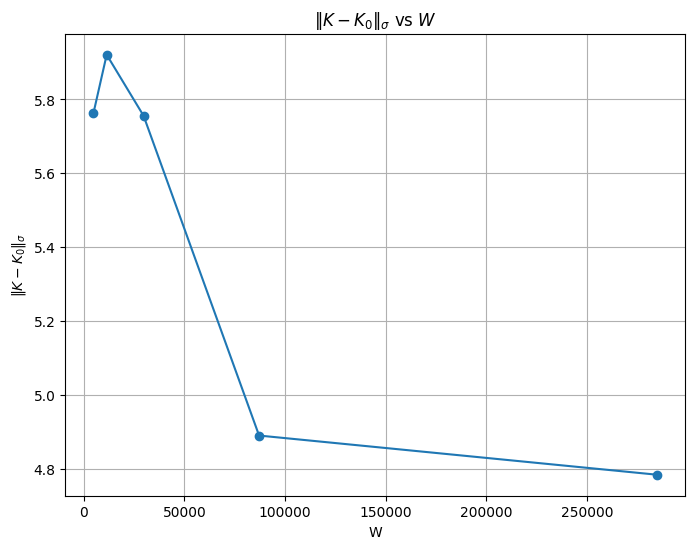

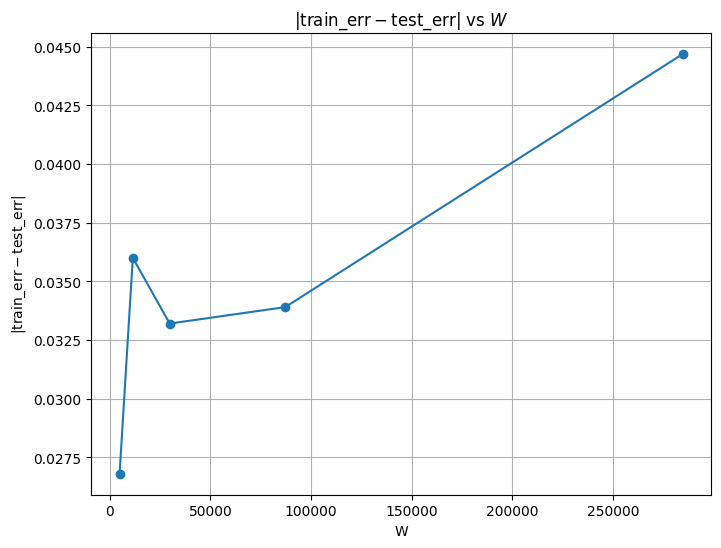

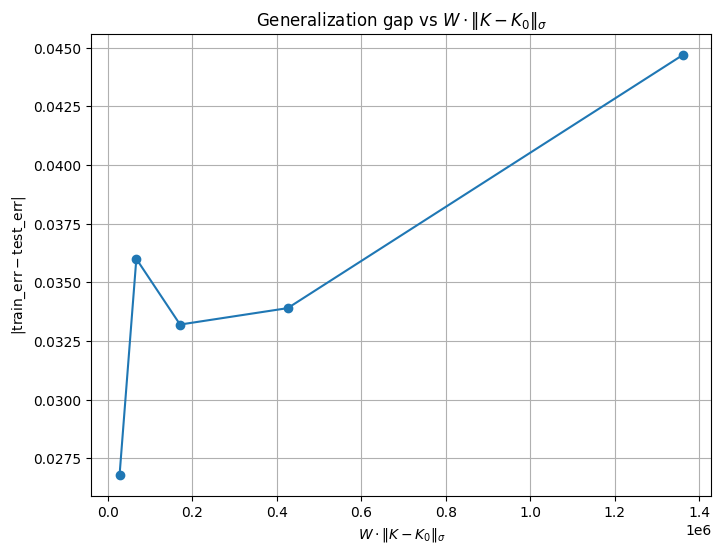

In [4]:

#  Visualizations

W, dist_init, gen_gaps, Wdist = run_experiment()

# ||K-K0||_sigma vs W
plt.figure(figsize=(8, 6))
plt.plot(W, dist_init, marker='o', linestyle='-')
plt.title(r"$\|K-K_0\|_{\sigma}$ vs $W$")
plt.xlabel("W")
plt.ylabel(r"$\|K-K_0\|_{\sigma}$")
plt.grid(True)
plt.show()

# Generalization gap vs W
plt.figure(figsize=(8, 6))
plt.plot(W, gen_gaps, marker='o', linestyle='-')
plt.title(r"$|\mathrm{train\_err}-\mathrm{test\_err}|$ vs $W$")
plt.xlabel("W")
plt.ylabel(r"$|\mathrm{train\_err}-\mathrm{test\_err}|$")
plt.grid(True)
plt.show()

# Generalization gap vs W * ||K-K0||_sigma
plt.figure(figsize=(8, 6))
plt.plot(Wdist, gen_gaps, marker='o', linestyle='-')
plt.title(r"Generalization gap vs $W \cdot \|K-K_0\|_{\sigma}$")
plt.xlabel(r"$W \cdot \|K-K_0\|_{\sigma}$")
plt.ylabel(r"$|\mathrm{train\_err}-\mathrm{test\_err}|$")
plt.grid(True)
plt.show()